# Exam Project

Import and set magics:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#%pip install git+https://github.com/alemartinello/dstapi

# import user-defined modules
from ExchangeEconomyModel import ExchangeEconomyModelClass
from ASADModel import ASADModelClass 

# APIs
from dstapi import DstApi

%load_ext autoreload
%autoreload 2

## Danish House Prices

### Question 1.1

In [2]:
# Download and clean data
EJ56 = DstApi('EJ56')
params = {
    'table': 'EJ56', 'format': 'BULK', 'lang': 'da',
    'variables': [
        {'code': 'OMRÅDE', 'values': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']},
        {'code': 'EJENDOMSKATE', 'values': ['0111', '0801', '2103']},
        {'code': 'TAL', 'values': ['100']},
        {'code': 'Tid', 'values': ['*']}
    ]
}

df = EJ56.get_data(params=params)
df = df.replace('..', np.nan).dropna(subset=['INDHOLD'])
df['INDHOLD'] = df['INDHOLD'].str.replace(',', '.').astype(float)
df = df.rename(columns={'INDHOLD': 'Indeks', 'TID': 'Kvartal', 'OMRÅDE': 'Landsdel', 'EJENDOMSKATE': 'Ejendomskategori'})

# Extract time and filter complete series
df['År'] = df['Kvartal'].str[:4].astype(int)
df['Kvartal_nr'] = df['Kvartal'].str[-1].astype(int)
df = df.sort_values(['Landsdel', 'Ejendomskategori', 'År', 'Kvartal_nr']).reset_index(drop=True)

earliest_quarter = df['Kvartal'].min()
landsdele_to_keep = [
    (l, e) for e in df['Ejendomskategori'].unique() 
    for l in df[df['Ejendomskategori'] == e]['Landsdel'].unique()
    if df[(df['Landsdel'] == l) & (df['Ejendomskategori'] == e)]['Kvartal'].min() == earliest_quarter
]
df = df[df.apply(lambda row: (row['Landsdel'], row['Ejendomskategori']) in landsdele_to_keep, axis=1)].reset_index(drop=True)

# Reindex to 1992Q1 = 100
df['Indeks_1992'] = df.groupby(['Landsdel', 'Ejendomskategori'], group_keys=False)['Indeks'].apply(lambda x: (x / x.iloc[0]) * 100)



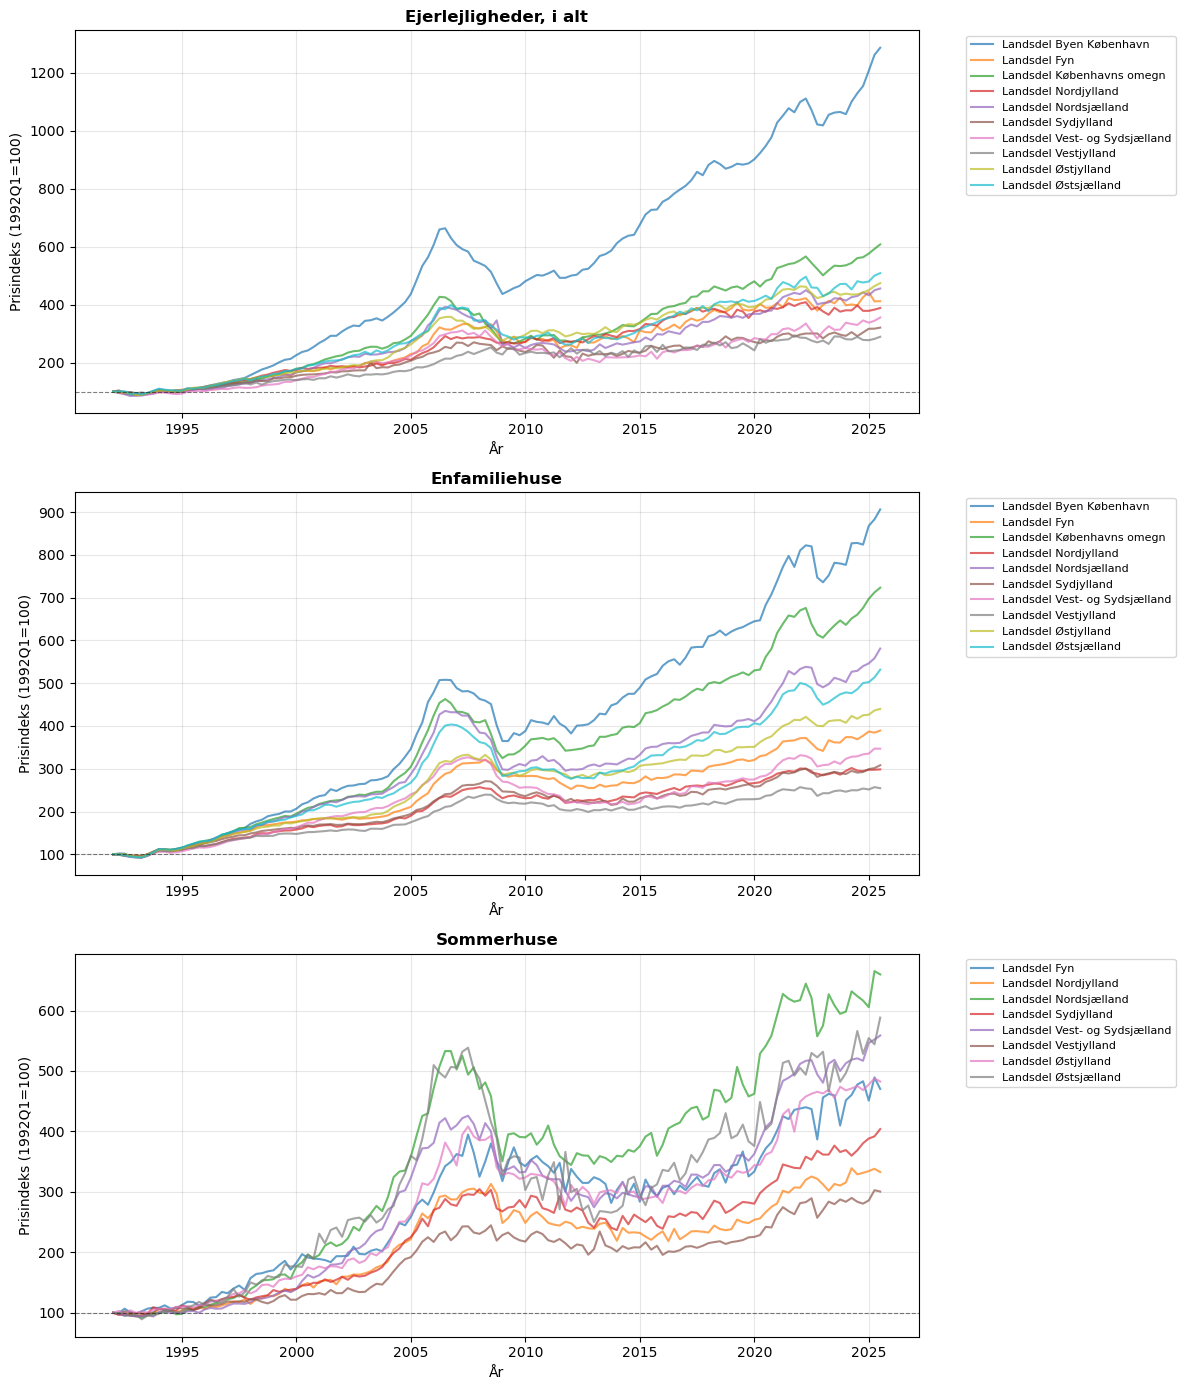

In [3]:
# Plotting the property price development
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

for idx, prop_type in enumerate(df['Ejendomskategori'].unique()):
    ax = axes[idx]
    df_prop = df[df['Ejendomskategori'] == prop_type]
    
    for landsdel in sorted(df_prop['Landsdel'].unique()):
        df_plot = df_prop[df_prop['Landsdel'] == landsdel].sort_values(['År', 'Kvartal_nr'])
        ax.plot(df_plot['År'] + (df_plot['Kvartal_nr']-1)/4, df_plot['Indeks_1992'], label=landsdel, alpha=0.7)
    
    ax.set_title(f'{prop_type}', fontsize=12, fontweight='bold')
    ax.set_xlabel('År')
    ax.set_ylabel('Prisindeks (1992Q1=100)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=100, color='black', linestyle='--', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.show()



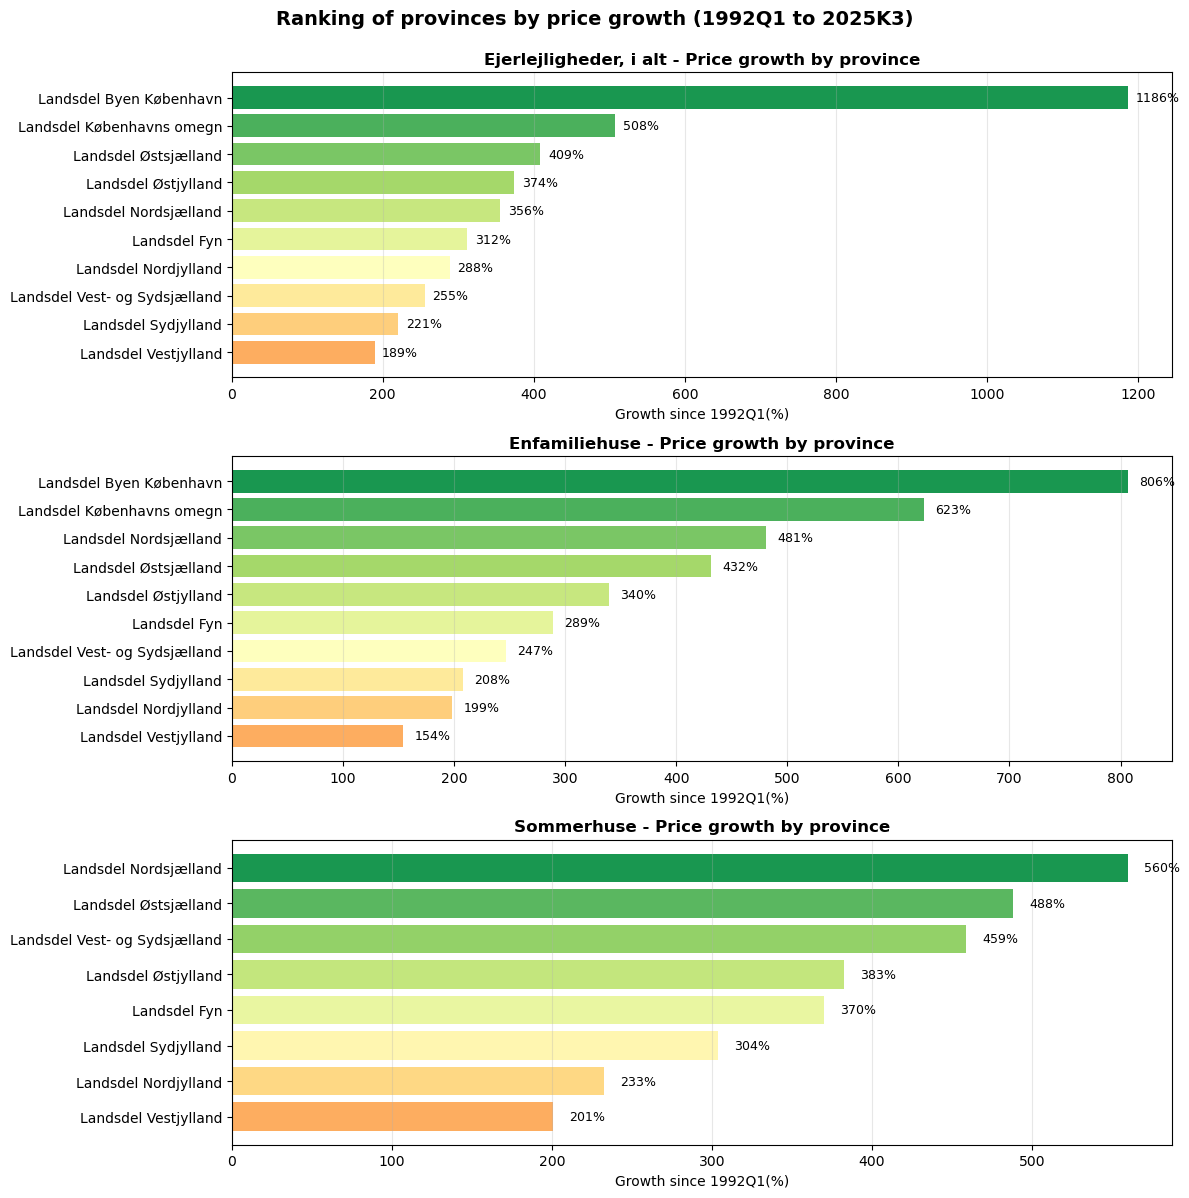

In [4]:
# Ranking of landsdele by price growth
latest_data = df[df['Kvartal'] == df['Kvartal'].max()].copy()
latest_data['Vækst (%)'] = latest_data['Indeks_1992'] - 100

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for idx, ejendom in enumerate(sorted(latest_data['Ejendomskategori'].unique())):
    df_rank = latest_data[latest_data['Ejendomskategori'] == ejendom].sort_values('Indeks_1992', ascending=True)
    ax = axes[idx]
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(df_rank)))
    ax.barh(df_rank['Landsdel'], df_rank['Vækst (%)'], color=colors)
    ax.set_xlabel('Growth since 1992Q1(%)', fontsize=10)
    ax.set_title(f'{ejendom} - Price growth by province', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, (landsdel, vækst) in enumerate(zip(df_rank['Landsdel'], df_rank['Vækst (%)'])):
        ax.text(vækst + 10, i, f'{vækst:.0f}%', va='center', fontsize=9)

plt.suptitle(f'Ranking of provinces by price growth (1992Q1 to {df["Kvartal"].max()})', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

#### Question 1.b

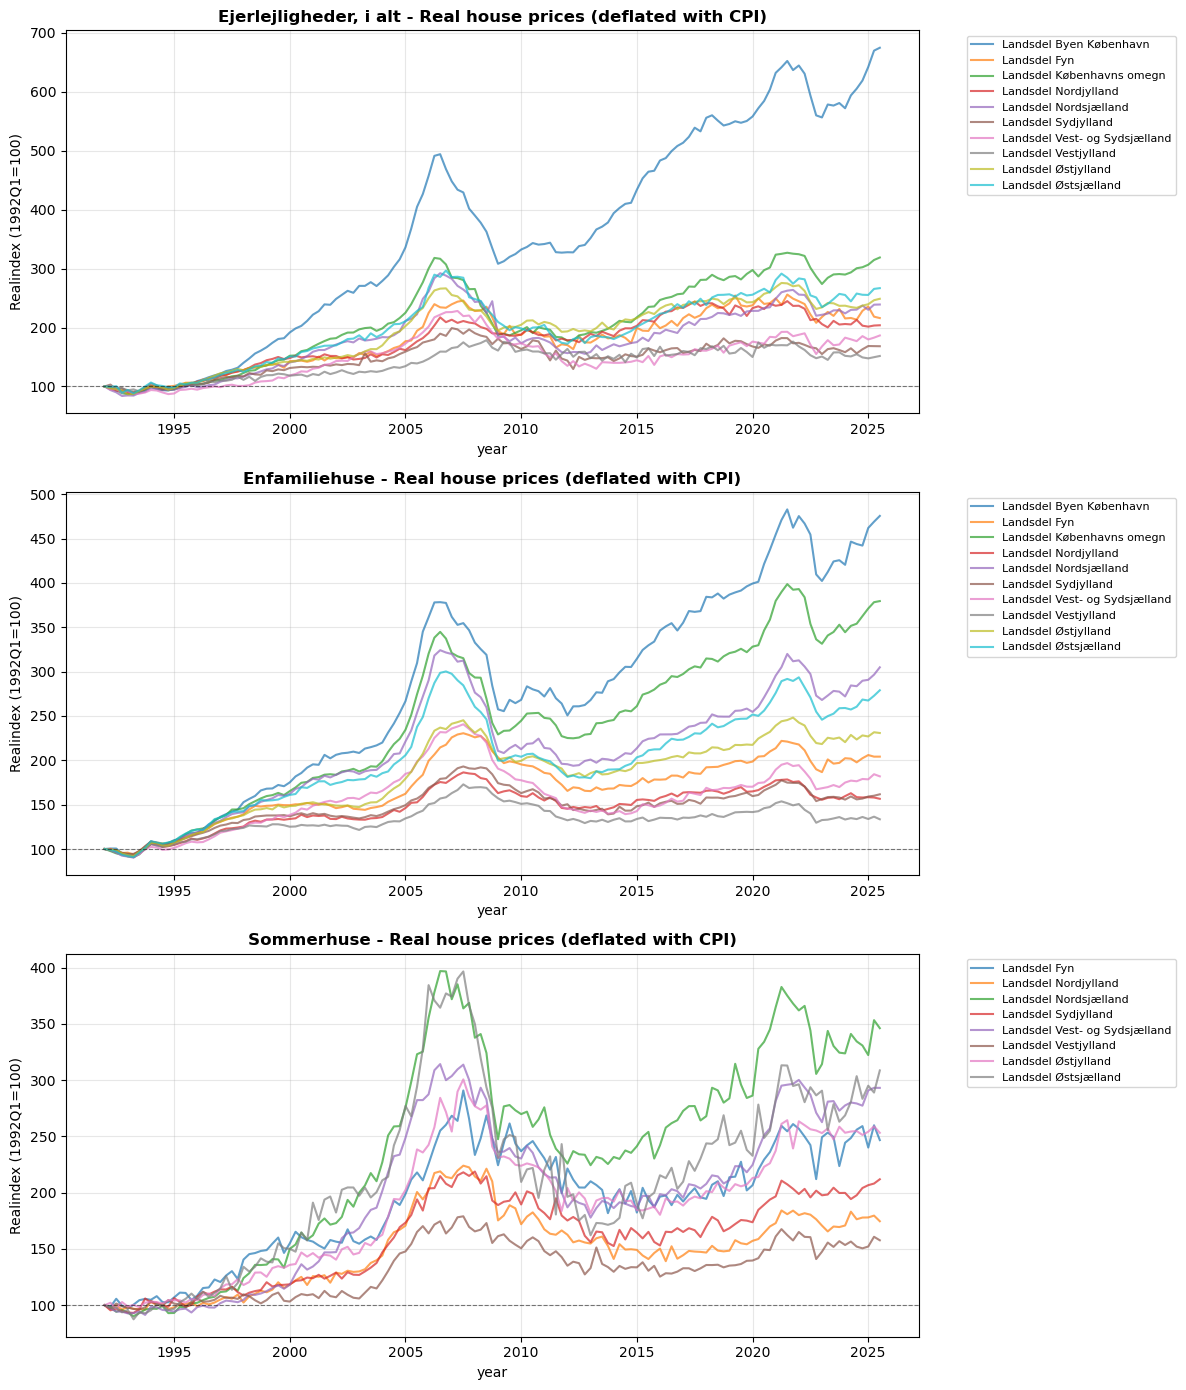

In [5]:
# Download and merge CPI data
PRIS113 = DstApi('PRIS113')
df_cpi = PRIS113.get_data(params={
    'table': 'PRIS113', 'format': 'BULK', 'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['INDEKS']},
        {'code': 'Tid', 'values': ['*']}
    ]
})

df_cpi.columns = ['TYPE', 'TIME', 'CPI']
df_cpi['CPI'] = df_cpi['CPI'].astype(float)
df_cpi['Quarter_Period'] = pd.to_datetime(df_cpi['TIME'].str.replace('M', ''), format='%Y%m').dt.to_period('Q')
df_cpi_q = df_cpi.groupby('Quarter_Period')['CPI'].mean().reset_index()

# Merge with house price data
df['Quarter_Period'] = pd.PeriodIndex(df['Kvartal'].str.replace('K', 'Q'), freq='Q')
df_real = df.merge(df_cpi_q, on='Quarter_Period', how='left')
df_real['Real_Index'] = (df_real['Indeks'] / df_real['CPI']) * 100
df_real['Real_Index_1992'] = df_real.groupby(['Landsdel', 'Ejendomskategori'], group_keys=False)['Real_Index'].apply(lambda x: x / x.iloc[0] * 100)

# Plot real prices
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

for idx, prop_type in enumerate(df_real['Ejendomskategori'].unique()):
    ax = axes[idx]
    df_prop = df_real[df_real['Ejendomskategori'] == prop_type]
    
    for landsdel in sorted(df_prop['Landsdel'].unique()):
        df_plot = df_prop[df_prop['Landsdel'] == landsdel]
        ax.plot(df_plot['År'] + (df_plot['Kvartal_nr']-1)/4, df_plot['Real_Index_1992'], label=landsdel, alpha=0.7)

    ax.set_title(f'{prop_type} - Real house prices (deflated with CPI)', fontsize=12, fontweight='bold')
    ax.set_xlabel('year')
    ax.set_ylabel('Realindex (1992Q1=100)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=100, color='black', linestyle='--', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.show()

#### Question 1.c

In [6]:
#downloading and cleaning data
BM = pd.read_excel('BM010_houses.xlsx', skiprows=2).iloc[:,2:] # skip first 2 columns and rows
BM = BM.rename(columns={'Unnamed: 2':'municipalities'})
BM = BM.replace('..', np.nan)
BM = BM.dropna()
# Calculate total growth from first to last year for each municipality
first_col = BM.columns[1]  # First year column (skip municipalities column)
last_col = BM.columns[-1]  # Last year column

BM['growth'] = ((BM[last_col] - BM[first_col]) / BM[first_col]) * 100
# Calculate correlation between initial level and growth
correlation = BM[first_col].corr(BM['growth'])
print(f'Correlation between initial level and growth: {correlation:.4f}')
# Identify top 5 municipalities by growth and initial level
top5_growth = BM.nlargest(5, 'growth')['municipalities'].tolist()
top5_initial = BM.nlargest(5, first_col)['municipalities'].tolist()

print("Top 5 municipalities by total growth:")
for i, muni in enumerate(top5_growth, 1):
    print(f"  {i}. {muni}")

print("\nTop 5 municipalities by initial house price level:")
for i, muni in enumerate(top5_initial, 1):
    print(f"  {i}. {muni}")



Correlation between initial level and growth: 0.8135
Top 5 municipalities by total growth:
  1. København
  2. Gentofte
  3. Lyngby-Taarbæk
  4. Gladsaxe
  5. Hvidovre

Top 5 municipalities by initial house price level:
  1. Vallensbæk
  2. Hørsholm
  3. Rudersdal
  4. Lyngby-Taarbæk
  5. Gentofte


C:\Users\schmi\AppData\Local\Temp\ipykernel_25388\502547221.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  BM = BM.replace('..', np.nan)
C:\Users\schmi\AppData\Local\Temp\ipykernel_25388\502547221.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  BM['growth'] = ((BM[last_col] - BM[first_col]) / BM[first_col]) * 100


There is positive correlation with between intial house price leve and total growth, and there is a high similariti beetween the top municipalities with the high initial price level and the top municipalities by total growth.  

#### Question 1.d


Top 10 most below peak:
municipality  change_pct
     Lolland  -18.954516
 Vordingborg  -17.526198
   Langeland  -13.095582
      Stevns  -11.174911
   Norddjurs  -10.729264
      Struer  -10.405709
   Odsherred  -10.176066
Guldborgsund   -9.361975
   Haderslev   -7.577323
     Halsnæs   -7.169885


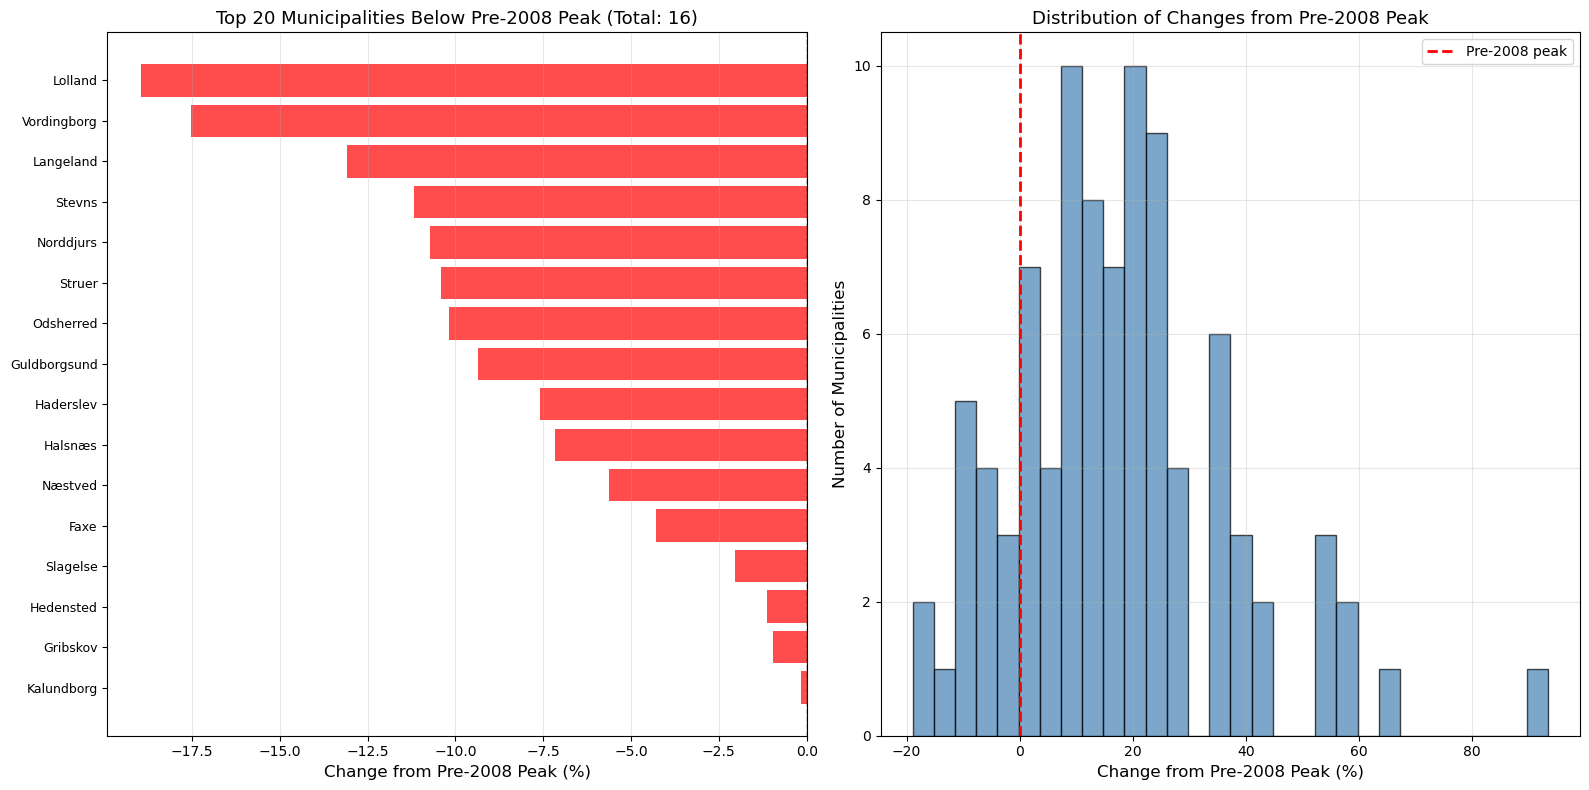

In [7]:
# Transpose and calculate 4-quarter rolling average
year_cols = [col for col in BM.columns if col not in ['municipalities', 'growth', 'label']]
BM_rolling = BM.set_index('municipalities')[year_cols].T.rolling(window=4, min_periods=1).mean()

# Identify pre-2008 periods
pre_2008_idx = [idx for idx in BM_rolling.index if int(str(idx)[:4]) < 2008]

# Calculate change from pre-2008 peak to latest
results = []
for muni in BM_rolling.columns:
    peak = BM_rolling[muni].loc[pre_2008_idx].max()
    latest = BM_rolling[muni].iloc[-1]
    change_pct = ((latest - peak) / peak) * 100
    results.append({'municipality': muni, 'change_pct': change_pct, 'still_below': latest < peak})

results_df = pd.DataFrame(results)
below_peak = results_df[results_df['still_below']].sort_values('change_pct')

print(f"\nTop 10 most below peak:\n{below_peak.head(10)[['municipality', 'change_pct']].to_string(index=False)}")
# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart of municipalities below peak
plot_data = below_peak.head(20)
ax1.barh(range(len(plot_data)), plot_data['change_pct'], color='red', alpha=0.7)
ax1.set_yticks(range(len(plot_data)))
ax1.set_yticklabels(plot_data['municipality'], fontsize=9)
ax1.axvline(0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Change from Pre-2008 Peak (%)', fontsize=12)
ax1.set_title(f'Top 20 Municipalities Below Pre-2008 Peak (Total: {len(below_peak)})', fontsize=13)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Distribution histogram
ax2.hist(results_df['change_pct'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Pre-2008 peak')
ax2.set_xlabel('Change from Pre-2008 Peak (%)', fontsize=12)
ax2.set_ylabel('Number of Municipalities', fontsize=12)
ax2.set_title('Distribution of Changes from Pre-2008 Peak', fontsize=13)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Exchange economy

### Question 2.1

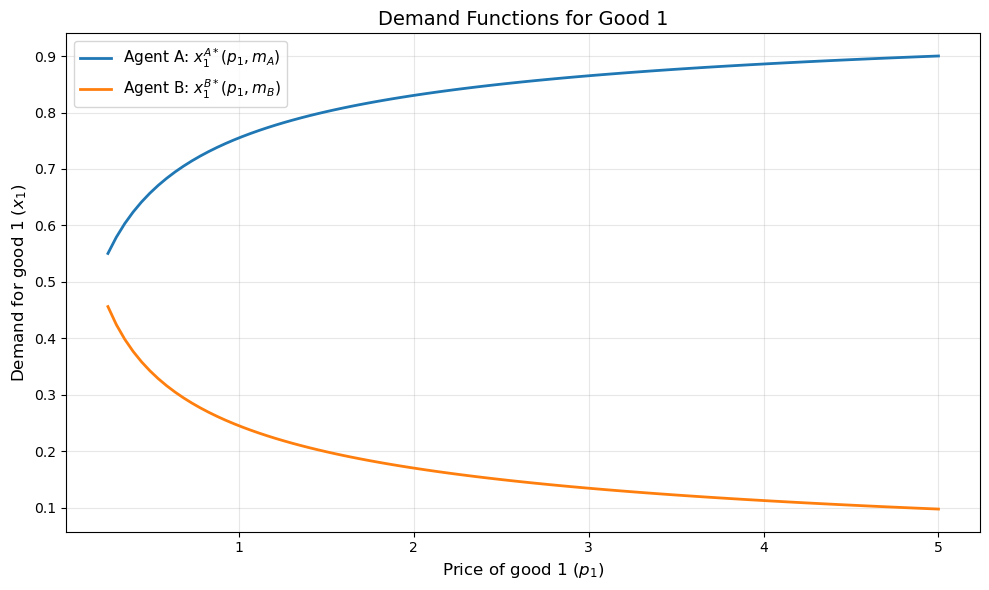

In [8]:
model = ExchangeEconomyModelClass()
p1 = np.linspace(0.25, 5, 100)
par = model.par

# Calculate demands by looping through each price
x1_a = np.zeros(len(p1))
x2_a = np.zeros(len(p1))
x1_b = np.zeros(len(p1))
x2_b = np.zeros(len(p1))

for i, price in enumerate(p1):
    m_a = price * par.w1A + par.w2A
    m_b = price * (1 - par.w1A) + (1 - par.w2A)
    
    x1_a[i], x2_a[i] = model.demand_A(price, m_a)
    x1_b[i], x2_b[i] = model.demand_B(price, m_b)

# Plot demand for good 1 for both agents
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(p1, x1_a, label='Agent A: $x_1^{A*}(p_1, m_A)$', linewidth=2)
ax.plot(p1, x1_b, label='Agent B: $x_1^{B*}(p_1, m_B)$', linewidth=2)

ax.set_xlabel('Price of good 1 ($p_1$)', fontsize=12)
ax.set_ylabel('Demand for good 1 ($x_1$)', fontsize=12)
ax.set_title('Demand Functions for Good 1', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Number of equilibria found: 3


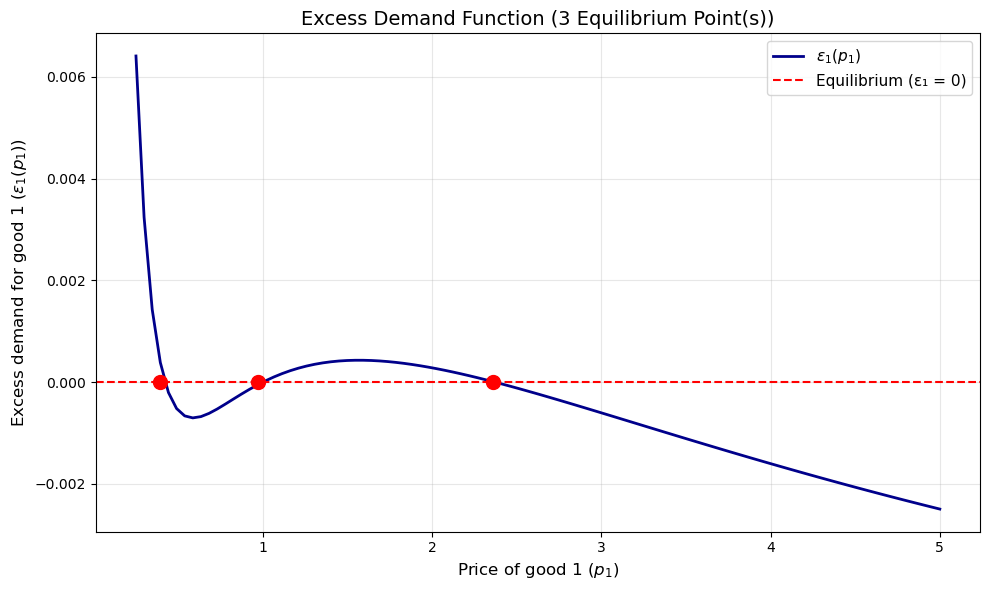

In [9]:
# Calculate excess demand for good 1
eps1 = (x1_a + x1_b) - 1

# Find all equilibria by detecting sign changes
sign_changes = np.where(np.diff(np.sign(eps1)))[0]

print(f"Number of equilibria found: {len(sign_changes)}")

# Plot excess demand with equilibria marked
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(p1, eps1, linewidth=2, color='darkblue', label='$\\varepsilon_1(p_1)$')
ax.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Equilibrium (ε₁ = 0)')

# Mark all equilibria
if len(sign_changes) > 0:
    for p1_eq in sign_changes:
        ax.plot(p1[p1_eq], 0, 'ro', markersize=10)

ax.set_xlabel('Price of good 1 ($p_1$)', fontsize=12)
ax.set_ylabel('Excess demand for good 1 ($\\varepsilon_1(p_1)$)', fontsize=12)
ax.set_title(f'Excess Demand Function ({len(sign_changes)} Equilibrium Point(s))', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Question 2.2


Starting with p0 = 0.9
 Converged after 33 iterations
  Equilibrium price: p1* = 0.421876
  Allocations: A=(0.6343, 0.1543), B=(0.3657, 0.8457)

Starting with p0 = 1.1
 Converged after 291 iterations
  Equilibrium price: p1* = 2.370356
  Allocations: A=(0.8457, 0.3657), B=(0.1543, 0.6343)


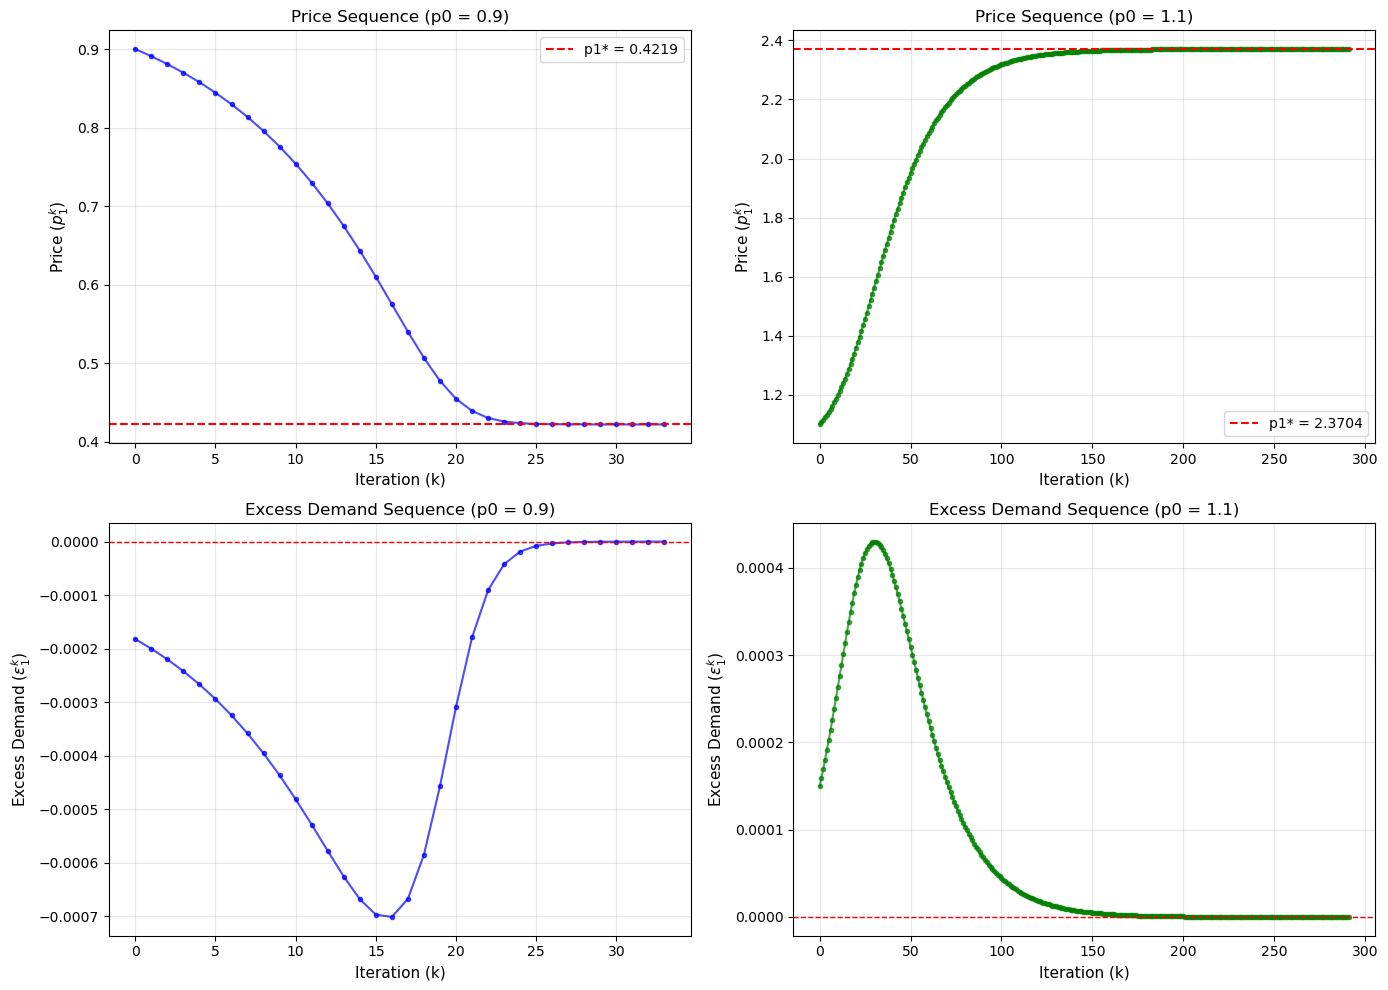

In [10]:
# Use solve_walras method for both initial guesses
p0_values = [0.9, 1.1]
results = {}

for p0 in p0_values:
    print(f"\nStarting with p0 = {p0}")
    
    # Solve using the model's solve_walras method
    converged, p_seq, eps_seq = model.solve_walras(p0, print_output=True, return_sequences=True)
    
    results[p0] = {
        'p_seq': p_seq,
        'eps_seq': eps_seq,
        'converged': converged,
        'iterations': model.sol.iterations if converged else model.par.K
        }
# Plot the sequences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['blue', 'green']

for i, p0 in enumerate(p0_values):
    p_seq = results[p0]['p_seq']
    eps_seq = results[p0]['eps_seq']
    k_values = np.arange(len(eps_seq))
    
    # Plot price sequence
    ax1 = axes[0, i]
    ax1.plot(k_values, p_seq[:len(eps_seq)], '-o', markersize=3, color=colors[i], alpha=0.7)
    if results[p0]['converged']:
        ax1.axhline(p_seq[-1], color='red', linestyle='--', label=f"p1* = {p_seq[-1]:.4f}")
    ax1.set_xlabel('Iteration (k)', fontsize=11)
    ax1.set_ylabel('Price ($p_1^k$)', fontsize=11)
    ax1.set_title(f'Price Sequence (p0 = {p0})', fontsize=12)
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot excess demand sequence
    ax2 = axes[1, i]
    ax2.plot(k_values, eps_seq, '-o', markersize=3, color=colors[i], alpha=0.7)
    ax2.axhline(0, color='red', linestyle='--', linewidth=1)
    ax2.set_xlabel('Iteration (k)', fontsize=11)
    ax2.set_ylabel('Excess Demand ($\\varepsilon_1^k$)', fontsize=11)
    ax2.set_title(f'Excess Demand Sequence (p0 = {p0})', fontsize=12)
    ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Different initial guesses lead to different equilibria. This suggests multiple equilibria exist and the choice of initial guess determines which one is found.

#### Question 2.3

Found 2 unique equilibria from 50 initial guesses:
  p1* = 0.4219 (found 8 times)
  p1* = 2.3704 (found 42 times)


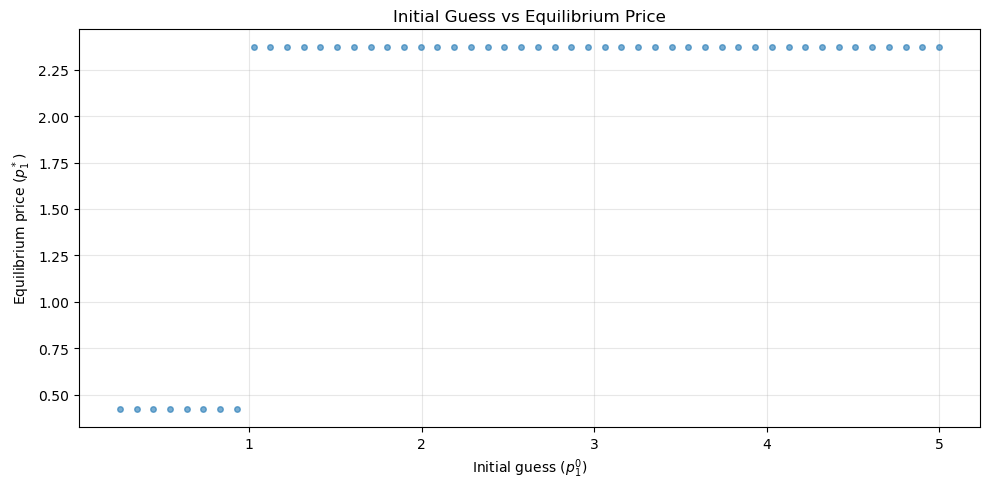

In [11]:
p0_grid = np.linspace(0.25, 5, 50)
equilibrium_prices = np.array([model.solve_walras(p0, print_output=False) and model.sol.p1 for p0 in p0_grid])

unique_equilibria = np.unique(np.round(equilibrium_prices, 4))
print(f"Found {len(unique_equilibria)} unique equilibria from {len(p0_grid)} initial guesses:")
for i, eq in enumerate(unique_equilibria):
    count = np.sum(np.abs(equilibrium_prices - eq) < 0.01)
    print(f"  p1* = {eq:.4f} (found {count} times)")

# Plot p0 vs p1*
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(p0_grid, equilibrium_prices, 'o', markersize=4, alpha=0.6)
ax.set_xlabel('Initial guess ($p_1^0$)')
ax.set_ylabel('Equilibrium price ($p_1^*$)')
ax.set_title('Initial Guess vs Equilibrium Price')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The missing equlibrium is unstable, and therefore there are only 2 stable equilibria. 

#### Question 2.4


Starting with p0 = 0.9:
Converged after 94 iterations: p1* = 0.999994

Starting with p0 = 1.1:
Converged after 92 iterations: p1* = 1.000005
Found 3 unique equilibria from 50 initial guesses:
  p1* = 0.4219 (found 4 times)
  p1* = 1.0000 (found 10 times)
  p1* = 2.3704 (found 36 times)


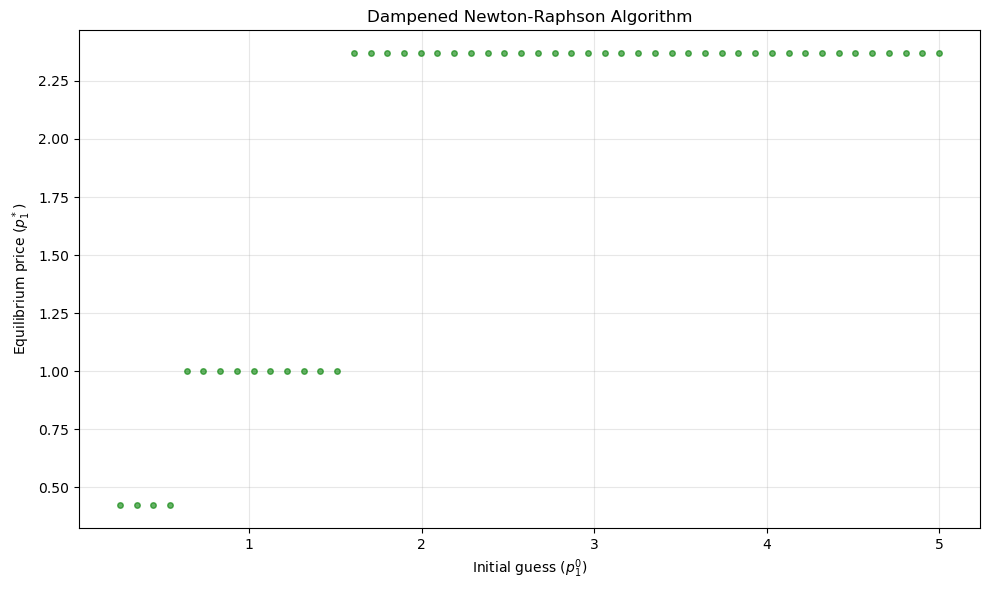

In [12]:
for p0 in [0.9, 1.1]:
    print(f"\nStarting with p0 = {p0}:")
    model.dampened_newton_raphson(p0, print_output=True)

p0_grid_nr = np.linspace(0.25, 5, 50)
equilibrium_prices_nr = np.array([model.dampened_newton_raphson(p0) and model.sol.p1 for p0 in p0_grid_nr])

unique_equilibria_nr = np.unique(np.round(equilibrium_prices_nr, 4))
print(f"Found {len(unique_equilibria_nr)} unique equilibria from {len(p0_grid_nr)} initial guesses:")
for eq in unique_equilibria_nr:
    count = np.sum(np.abs(equilibrium_prices_nr - eq) < 0.01)
    print(f"  p1* = {eq:.4f} (found {count} times)")

# Plot Newton-Raphson results
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(p0_grid_nr, equilibrium_prices_nr, 'o', markersize=4, alpha=0.6, color='green')
ax.set_xlabel('Initial guess ($p_1^0$)')
ax.set_ylabel('Equilibrium price ($p_1^*$)')
ax.set_title('Dampened Newton-Raphson Algorithm')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Unlike the tâtonnement algorithm which only found 2 stable equilibria, the dampened Newton-Raphson algorithm successfully converges to all 3 equilibria, including the unstable one

#### Question 2.5

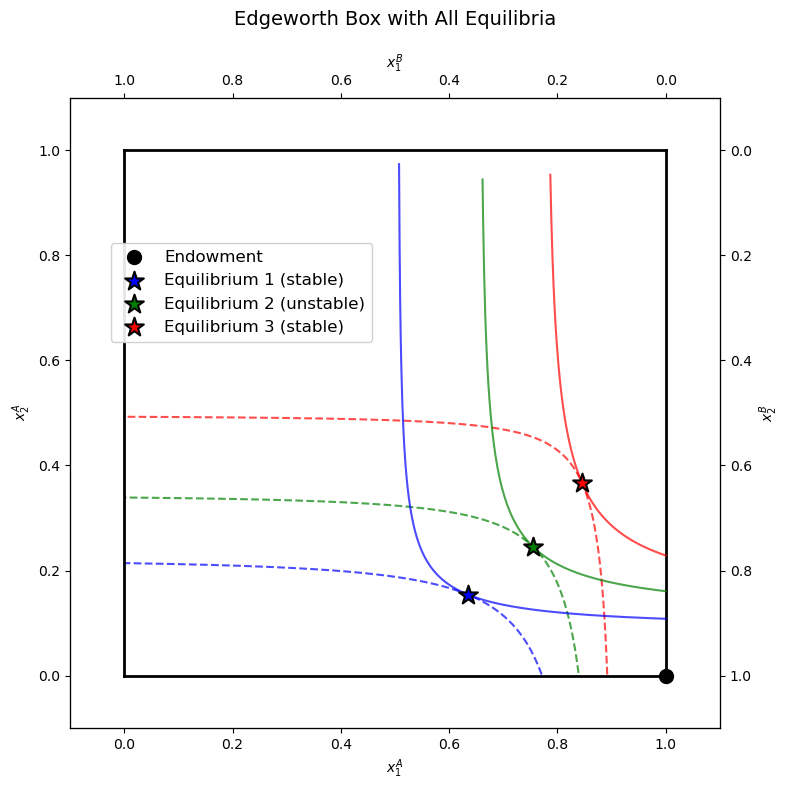

In [13]:
# Plot Edgeworth box with all equilibria
fig, ax_A, ax_B = model.create_edgeworthbox(figsize=(8, 8))

# Plot endowment point
ax_A.scatter(par.w1A, par.w2A, marker='o', s=100, color='black', zorder=10, label='Endowment')

# All three equilibria found
equilibria_prices = [0.4219, 1.0000, 2.3704]
colors_eq = ['blue', 'green', 'red']
labels = ['Equilibrium 1 (stable)', 'Equilibrium 2 (unstable)', 'Equilibrium 3 (stable)']

for i, p1_eq in enumerate(equilibria_prices):
    # Solve for allocations at this equilibrium
    m_a = p1_eq * par.w1A + par.w2A
    m_b = p1_eq * (1 - par.w1A) + (1 - par.w2A)
    
    x1A, x2A = model.demand_A(p1_eq, m_a)
    x1B, x2B = model.demand_B(p1_eq, m_b)
    
    # Plot equilibrium allocation
    ax_A.scatter(x1A, x2A, marker='*', s=200, color=colors_eq[i], 
                edgecolor='black', linewidth=1.5, zorder=10, label=labels[i])
    
    # Plot indifference curves through equilibrium
    model.indifference_curve_A(ax_A, x1A, x2A, color=colors_eq[i], linestyle='-', linewidth=1.5, alpha=0.7)
    model.indifference_curve_B(ax_B, x1B, x2B, color=colors_eq[i], linestyle='--', linewidth=1.5, alpha=0.7)


model.add_legend(ax_A, ax_B, bbox_to_anchor=(0.05, 0.60))
plt.title('Edgeworth Box with All Equilibria', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## The AS-AD Model

#### Question 3.1

Analytical Equilibrium after shock (pi_e=0.08):
  y* = 0.9884
  pi* = 0.0336


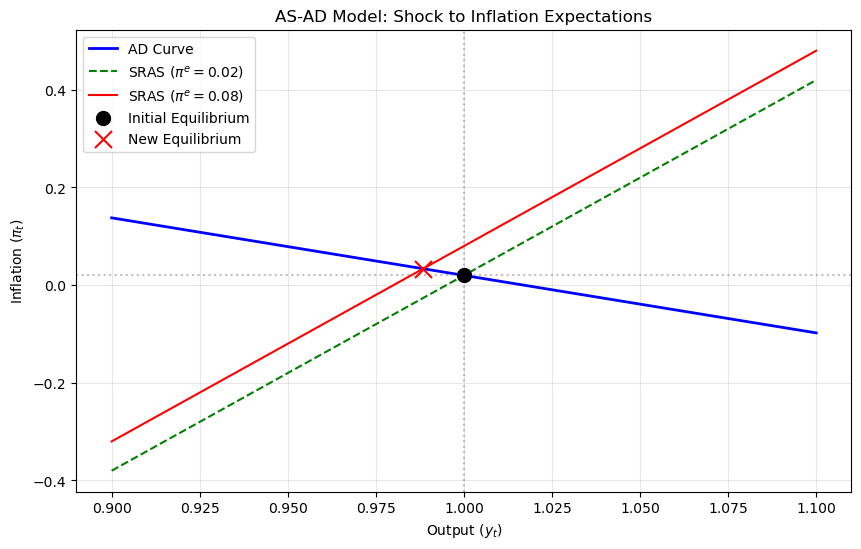

In [ ]:
# 1. Setup Model
model = ASADModelClass()
par = model.par 

# 3. Calculate Curves for Plotting
y_grid = np.linspace(0.9, 1.1, 100)

# AD Curve (v = 0, no demand shock)
AD_curve = [model.AD_curve(y, v=0) for y in y_grid]

# SRAS Curve 1: Long-run equilibrium (pi_e = pi_star = 0.02)
SRAS_base = [model.SRAS_curve(y, pi_e=par['pi_star']) for y in y_grid]

# SRAS Curve 2: Shock to expectations (pi_e = 0.08)
pi_e_shock = 0.08
SRAS_shock = [model.SRAS_curve(y, pi_e=pi_e_shock) for y in y_grid]

# 4. Calculate Analytical Equilibrium after shock
y_star_shock, pi_star_new = model.equilibrium(pi_e=pi_e_shock, v=0)

print(f"Analytical Equilibrium after shock (pi_e={pi_e_shock}):")
print(f"  y* = {y_star_shock:.4f}")
print(f"  pi* = {pi_star_new:.4f}")

# 5. Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot AD
ax.plot(y_grid, AD_curve, label='AD Curve', color='blue', linewidth=2)

# Plot SRAS
ax.plot(y_grid, SRAS_base, label='SRAS ($\pi^e = 0.02$)', color='green', linestyle='--')
ax.plot(y_grid, SRAS_shock, label='SRAS ($\pi^e = 0.08$)', color='red')

# Plot Equilibria
# Initial Long-Run Equilibrium
ax.scatter(par['ybar'], par['pi_star'], color='black', s=100, zorder=5, label='Initial Equilibrium')

# New Short-Run Equilibrium
ax.scatter(y_star_shock, pi_star_new, color='red', marker='x', s=150, zorder=5, label='New Equilibrium')

# Formatting
ax.set_title('AS-AD Model: Shock to Inflation Expectations')
ax.set_xlabel('Output ($y_t$)')
ax.set_ylabel('Inflation ($\pi_t$)')
ax.axvline(par['ybar'], color='gray', linestyle=':', alpha=0.5)
ax.axhline(par['pi_star'], color='gray', linestyle=':', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

#### Question 3.2

Simulation Results:
----------------------------------------------------------------------
t     v_t          π_e[t]       y*[t]        π*[t]       
----------------------------------------------------------------------
0     0.1000       0.0200       1.0215       0.1058      
1     0.0000       0.0543       0.9934       0.0278      
2     0.0000       0.0437       0.9954       0.0254      
3     0.0000       0.0364       0.9968       0.0237      
4     0.0000       0.0313       0.9978       0.0226      
5     0.0000       0.0278       0.9985       0.0218      
----------------------------------------------------------------------


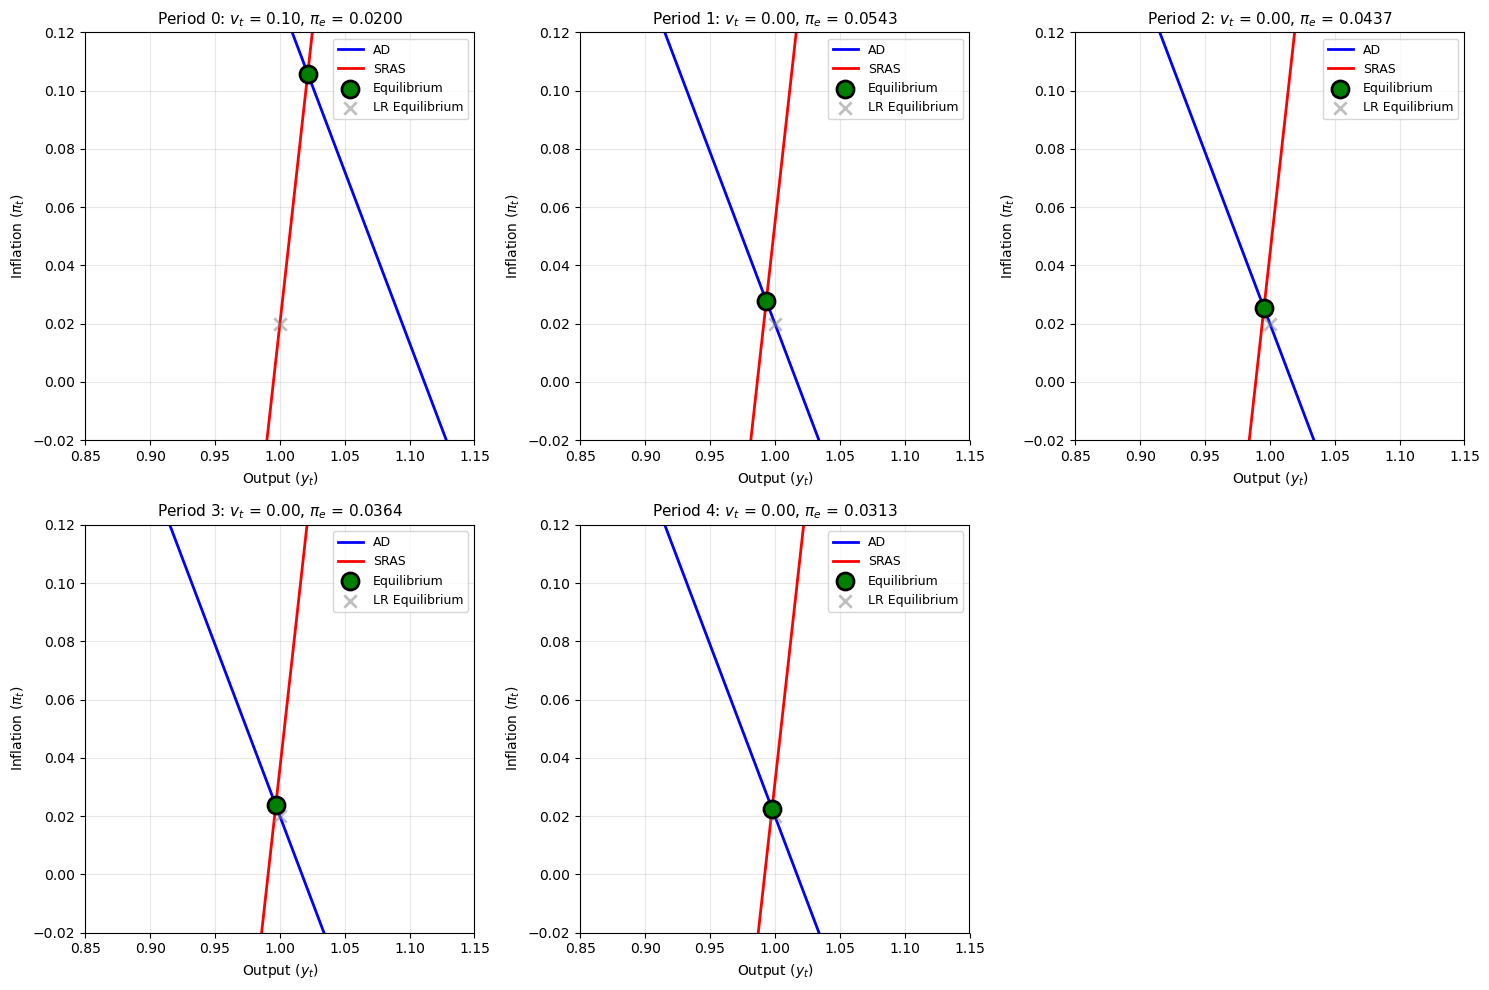

In [ ]:
# Parameters
T = 5
v_shock = 0.1
phi = par['phi']

# Initialize paths
pi_e_path = np.zeros(T + 1)
y_star_path = np.zeros(T + 1)
pi_star_path = np.zeros(T + 1)
v_path = np.zeros(T + 1)

pi_e_path[0] = par['pi_star']
v_path[0] = v_shock

# Simulate
for t in range(T + 1):
    if t > 0:
        pi_e_path[t] = phi * pi_e_path[t - 1] + (1 - phi) * pi_star_path[t - 1]
        v_path[t] = 0
    y_star_path[t], pi_star_path[t] = model.equilibrium(pi_e_path[t], v_path[t])

# Print results
print("Simulation Results:")
print("-" * 70)
print(f"{'t':<5} {'v_t':<12} {'π_e[t]':<12} {'y*[t]':<12} {'π*[t]':<12}")
print("-" * 70)
for t in range(T + 1):
    print(f"{t:<5} {v_path[t]:<12.4f} {pi_e_path[t]:<12.4f} {y_star_path[t]:<12.4f} {pi_star_path[t]:<12.4f}")
print("-" * 70)

# Plot
y_grid = np.linspace(0.85, 1.15, 100)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for t, ax in enumerate(axes.flatten()[:T + 1]):
    AD_curve = [model.AD_curve(y, v=v_path[t]) for y in y_grid]
    SRAS_curve = [model.SRAS_curve(y, pi_e=pi_e_path[t]) for y in y_grid]
    
    ax.plot(y_grid, AD_curve, label='AD', color='blue', linewidth=2)
    ax.plot(y_grid, SRAS_curve, label='SRAS', color='red', linewidth=2)
    ax.scatter(y_star_path[t], pi_star_path[t], color='green', s=150, 
               zorder=5, marker='o', edgecolor='black', linewidth=2, label='Equilibrium')
    ax.scatter(par['ybar'], par['pi_star'], color='gray', s=80, 
               zorder=4, marker='x', linewidth=2, alpha=0.5, label='LR Equilibrium')
    
    ax.set_xlabel('Output ($y_t$)', fontsize=10)
    ax.set_ylabel('Inflation ($\pi_t$)', fontsize=10)
    ax.set_title(f'Period {t}: $v_t$ = {v_path[t]:.2f}, $\pi_e$ = {pi_e_path[t]:.4f}', fontsize=11)
    ax.set_xlim(0.85, 1.15)
    ax.set_ylim(-0.02, 0.12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

axes.flatten()[-1].set_visible(False)
plt.tight_layout()
plt.savefig('Q2_Demand_Shock_Simulation.png', dpi=300, bbox_inches='tight')
plt.show()

#### Question 3.3

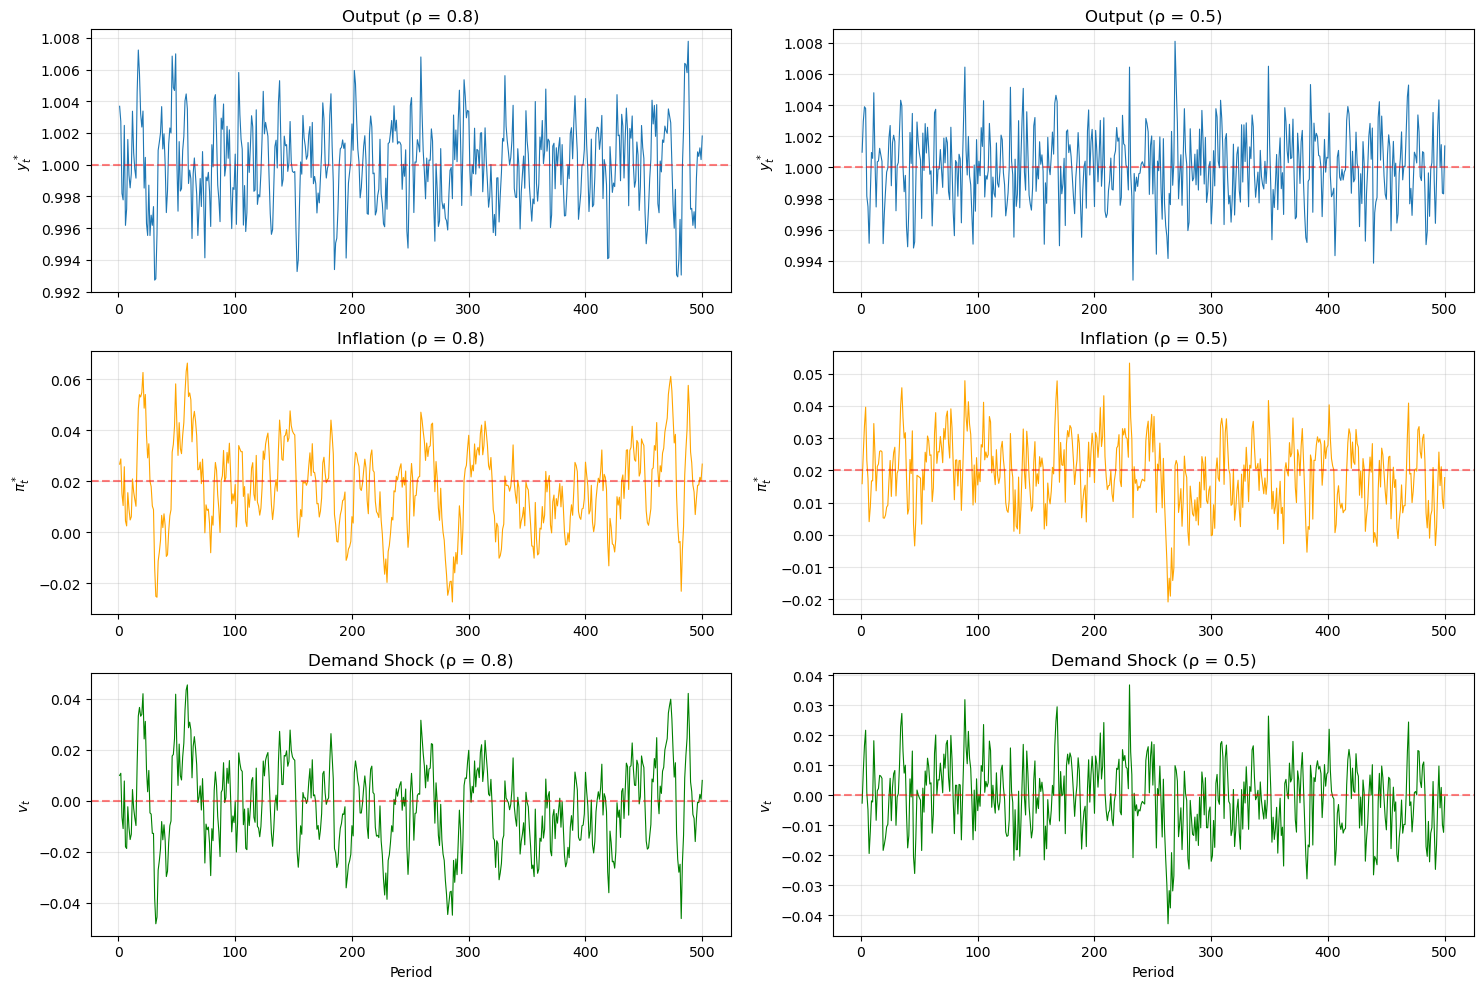



SUMMARY STATISTICS
ρ        Std(y)          Std(π)          Corr(y,π)      
0.80     0.002705        0.016800        0.515039       
0.50     0.002348        0.010937        0.686365       


In [16]:
# setting seed
np.random.seed(123)

# Parameters
T = 500
rho_values = [0.8, 0.5]
sigma_e = 0.01

results = {}

for rho in rho_values:
    # Generate shocks
    eps = np.random.normal(0, sigma_e, T + 1)
    
    # Simulate using model method
    sim = model.simulate(rho, eps, T)
    
    # Calculate moments using model method
    moments = model.moments(sim['y'], sim['pi'])
    
    # Store results
    results[rho] = {
        'y_path': sim['y'],
        'pi_path': sim['pi'],
        'v_path': sim['v'],
        'y_sd': moments['y_sd'],
        'pi_sd': moments['pi_sd'],
        'corr': moments['corr']
    }

# Plot comparison
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for col, rho in enumerate(rho_values):
    t_axis = np.arange(1, T + 1)
    
    # Output
    axes[0, col].plot(t_axis, results[rho]['y_path'][1:], linewidth=0.8)
    axes[0, col].axhline(par['ybar'], color='red', linestyle='--', alpha=0.5)
    axes[0, col].set_title(f'Output (ρ = {rho})')
    axes[0, col].set_ylabel('$y_t^*$')
    axes[0, col].grid(alpha=0.3)
    
    # Inflation
    axes[1, col].plot(t_axis, results[rho]['pi_path'][1:], linewidth=0.8, color='orange')
    axes[1, col].axhline(par['pi_star'], color='red', linestyle='--', alpha=0.5)
    axes[1, col].set_title(f'Inflation (ρ = {rho})')
    axes[1, col].set_ylabel('$\pi_t^*$')
    axes[1, col].grid(alpha=0.3)
    
    # Demand shock
    axes[2, col].plot(t_axis, results[rho]['v_path'][1:], linewidth=0.8, color='green')
    axes[2, col].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[2, col].set_title(f'Demand Shock (ρ = {rho})')
    axes[2, col].set_xlabel('Period')
    axes[2, col].set_ylabel('$v_t$')
    axes[2, col].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Q3_Stochastic_Simulation.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary table
print("\n")
print("SUMMARY STATISTICS")
print(f"{'ρ':<8} {'Std(y)':<15} {'Std(π)':<15} {'Corr(y,π)':<15}")
for rho in rho_values:
    print(f"{rho:<8.2f} {results[rho]['y_sd']:<15.6f} {results[rho]['pi_sd']:<15.6f} {results[rho]['corr']:<15.6f}")